In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
import numpy as np
import torch

url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/Housing.csv'
df = pd.read_csv(url)

Pre-processing and Training

In [2]:
varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

def binary_mapping(x):
  return x.map({'yes' : 1, 'no' : 0})

df[varlist] = df[varlist].apply(binary_mapping)
df = df.drop('furnishingstatus', axis=1)

y = df.pop('price')
varlist = df.columns.tolist()
x = df.values

t_un = torch.tensor(StandardScaler().fit_transform(x), dtype=torch.float32)
t_u = torch.tensor(x, dtype=torch.float32)
t_c = torch.tensor(y, dtype=torch.float32)

Splitting Training and Validation Set

In [3]:
samples = t_un.shape[0]
values = int(0.2 * samples)

shuffle = torch.randperm(samples)
train_idx = shuffle[:-values]
valid_idx = shuffle[-values:]

t_un_train = t_un[train_idx]
t_un_valid = t_un[valid_idx]

t_u_train = t_u[train_idx]
t_u_valid = t_u[valid_idx]

t_c_train = t_c[train_idx]
t_c_valid = t_c[valid_idx]

Linear Regression Training

In [4]:
# Model and Training Functions
def lin_model(t_u, *params):
    params = torch.stack(params)
    return torch.matmul(t_u, params[:-1]) + params[-1]

def cost(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

def lin_training(epochs, optimizer, params, t_u_train, t_u_valid, t_c_train, t_c_valid):
    train_losses = []
    valid_losses = []
    for epoch in range(1, epochs+1):
        t_p_train = lin_model(t_u_train, *params)
        train_loss = cost(t_p_train, t_c_train)

        t_p_valid = lin_model(t_u_valid, *params)
        valid_loss = cost(t_p_valid, t_c_valid)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.detach().clone())
        valid_losses.append(valid_loss.detach().clone())

        if epoch % 500 == 0:
            print(f'Epochs: {epoch}, \tTraining Loss: {train_loss.item()}, \tValidation Loss: {valid_loss.item()}')
    return params, train_losses, valid_losses

Linear Regression Optimizer Loop and Plots


### SGD Optimized Linear Model with Learning Rate 0.1
Epochs: 500, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0
Epochs: 1000, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0
Epochs: 1500, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0
Epochs: 2000, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0
Epochs: 2500, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0
Epochs: 3000, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0
Epochs: 3500, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0
Epochs: 4000, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0
Epochs: 4500, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0
Epochs: 5000, 	Training Loss: 1034962927616.0, 	Validation Loss: 1622757605376.0

### SGD Optimized Linear Model with Learning Rate 0.01
Epochs: 500, 	Training Loss: 1034974593024.0, 	Validation Loss: 1623157637120.0


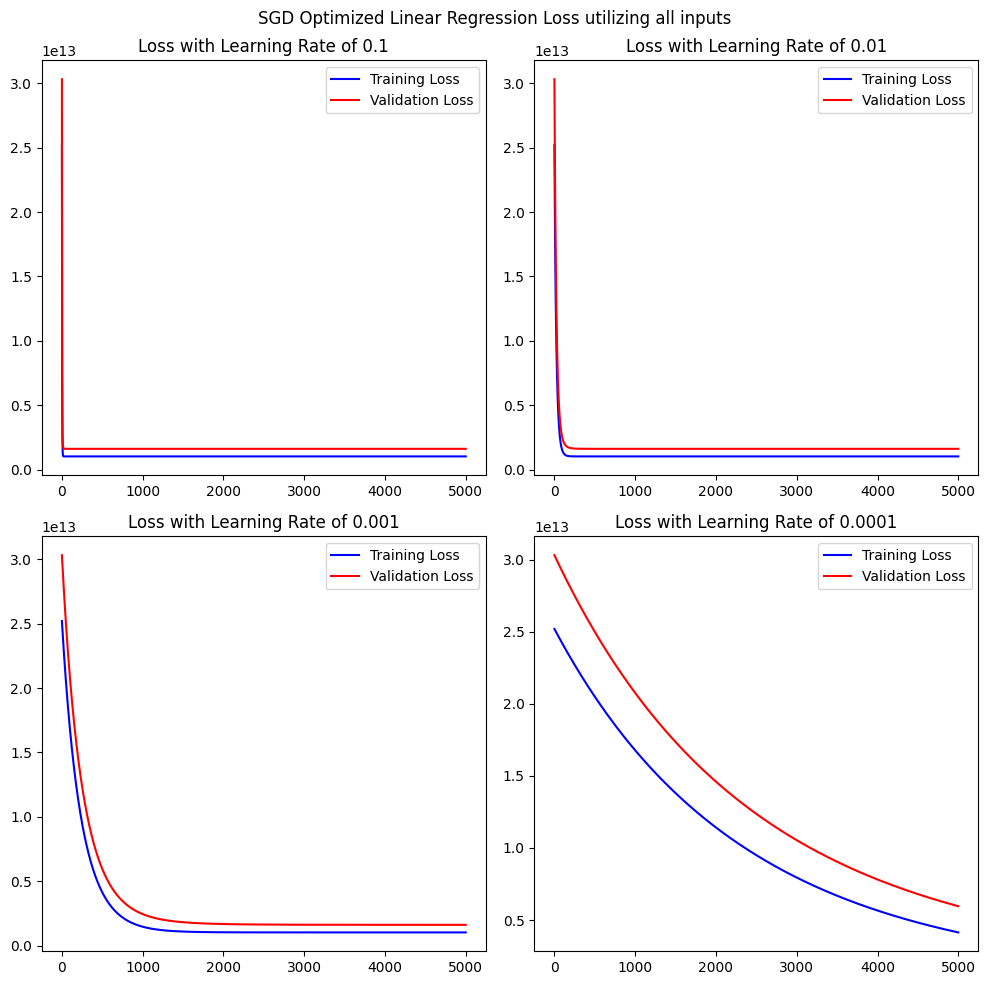

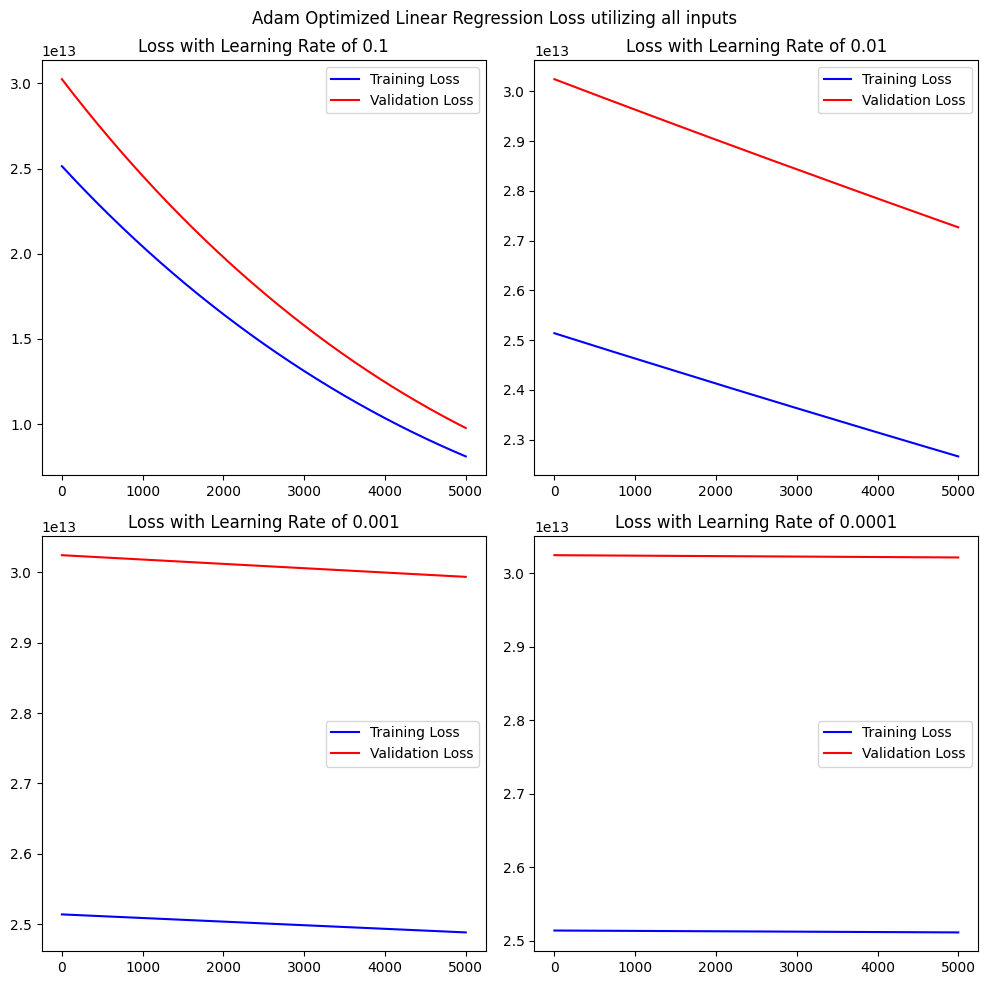

In [5]:
# Optimizer and Training for different Learning Rates
def run_optimizer(optimizer_type, learning_rates, t_u_train, t_u_valid, t_c_train, t_c_valid):
    results = {}
    for lr in learning_rates:
        # Initialize params as separate tensors for each parameter
        params = [torch.tensor(1.0, requires_grad=True) for _ in range(t_u_train.shape[1])] + [torch.tensor(0.0, requires_grad=True)]
        if optimizer_type == 'SGD':
            optimizer = optim.SGD(params, lr=lr)
        elif optimizer_type == 'Adam':
            optimizer = optim.Adam(params, lr=lr)

        print(f"\n### {optimizer_type} Optimized Linear Model with Learning Rate {lr}")
        model, trainLoss, validLoss = lin_training(5000, optimizer, params, t_u_train, t_u_valid, t_c_train, t_c_valid)

        results[lr] = {
            'trainLoss': np.array([item.item() for item in trainLoss]),
            'validLoss': np.array([item.item() for item in validLoss])
        }
    return results

# Define learning rates
sgd_learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
adam_learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

# Run SGD optimizer with scaled inputs
sgd_results = run_optimizer('SGD', sgd_learning_rates, t_un_train, t_un_valid, t_c_train, t_c_valid)

# Run Adam optimizer with unscaled inputs
adam_results = run_optimizer('Adam', adam_learning_rates, t_u_train, t_u_valid, t_c_train, t_c_valid)

# Plotting Results
def plot_loss(results, optimizer_type):
    plt.figure(figsize=(10, 10))
    plt.suptitle(f'{optimizer_type} Optimized Linear Regression Loss utilizing all inputs')

    for i, (lr, result) in enumerate(results.items(), 1):
        train_loss = result['trainLoss']
        valid_loss = result['validLoss']

        plt.subplot(2, 2, i)
        plt.plot(train_loss, color='blue', label='Training Loss')
        plt.plot(valid_loss, color='red', label='Validation Loss')
        plt.title(f'Loss with Learning Rate of {lr}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot loss for both optimizers
plot_loss(sgd_results, 'SGD')
plot_loss(adam_results, 'Adam')